# LArIAT Event Clustering Analysis

Object-oriented approach for analyzing LArIAT detector events. Implements clustering algorithms to identify particle tracks and energy deposits in collection and induction planes.

**Key Features:**
- Load raw ADC data from ROOT files
- Multiple clustering algorithms (connected regions, largest cluster, max ADC ratio)
- Visualization of detector planes with cluster overlays
- Analysis of both proton and deuteron events



In [1]:
import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

import cv2
from scipy import ndimage

In [2]:
DEUTERON1 = "/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008563_sr0086_20160530T071803_evtsel_1.root"


deuterons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/deuteron_candidates_bbox_t100.csv')
protons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/protons_one_track_filepaths.csv')

In [9]:
deuterons.columns

Index(['run', 'subrun', 'event', 'file_path', 'event_index', 'col_max_adc',
       'ind_max_adc', 'col_activity_pixels', 'ind_activity_pixels'],
      dtype='object')

In [3]:
class Event():

    def __init__(self, filepath, index=0):
        self.filepath = filepath
        self.index = index
        self.collection = None
        self.induction = None
        self.load()

    def load(self):

        file = uproot.open(self.filepath)
        tree = file["ana/raw"]
        event_data = tree.arrays(["run", "subrun", "event"], library="ak")

        run = ak.to_numpy(event_data["run"])[self.index]
        subrun = ak.to_numpy(event_data["subrun"])[self.index]
        event = ak.to_numpy(event_data["event"])[self.index]

        data = tree.arrays(["raw_rawadc", "raw_channel"], library="ak")[self.index]
        adc_data = ak.to_numpy(data["raw_rawadc"])
        channel_map = ak.to_numpy(data["raw_channel"])

        num_channels_in_event = len(channel_map) # 480 - 240 in collection, 240 in induction - number of wires
        num_ticks = len(adc_data) // num_channels_in_event
        adc_data2d = adc_data.reshape((num_channels_in_event, num_ticks))

        self.collection = np.zeros((240, num_ticks))
        self.induction = np.zeros((240, num_ticks))

        for i, channel_num in enumerate(channel_map):
            if 0 <= channel_num < 240:
                self.induction[channel_num, :] = adc_data2d[i, :]
            if 240 <= channel_num < 480:
                self.collection[channel_num - 240, :] = adc_data2d[i, :]          

    def plot(self, collection=None, induction=None):

        c = collection if collection is not None else self.collection
        i = induction if induction is not None else self.induction

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

        sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
        ax1.set_xlabel("Collection Plane Wire Number (0-239)")
        ax1.set_ylabel("Time Tick")
        ax1.set_title("Collection Plane")
        ax1.invert_yaxis()

        sns.heatmap(i.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
        ax2.set_xlabel("Induction Plane Wire Number (0-239)")
        ax2.set_ylabel("Time Tick")
        ax2.set_title("Induction Plane")
        ax2.invert_yaxis()

    def master(self, matrix, threshold=20):
        """Incorporate everything."""
        return

    def connectedregions(self, matrix, threshold=20):
        """Find connected regions of signal above threshold"""

        # Create binary mask (matrix 240 x 3072) of significant signals.
        # (True (1) for above threshold, False (0) for below threshold.)
        binary_mask = matrix > threshold
        
        # Label connected pixels
        labeled_regions, num_regions = label(binary_mask, return_num=True)
        
        print(f"Found {num_regions} connected regions")

        if num_regions == 0:
            return None, None
        
        # Properties of each region
        regions = regionprops(labeled_regions, intensity_image=matrix) # arg "intensity_image" re-introduces the ADC values, now that clusters are identified. 
        
        return labeled_regions, regions

    def longestcluster(self, matrix, threshold=20):
        """Find only the largest connected region above threshold"""
        binary_mask = matrix > threshold
        labeled_regions, num_regions = label(binary_mask, return_num=True)
        
        print(f"Found {num_regions} connected regions")
        
        if num_regions == 0:
            return None, None

        regions = regionprops(labeled_regions, intensity_image=matrix)
        
        # The largest region by area
        largest_region = max(regions, key=lambda r: r.area)
        largest_idx = regions.index(largest_region)
        
        # print(f"Largest Region:")
        # print(f"  Area: {largest_region.area} pixels")

        total_intensity = matrix[largest_region.coords[:, 0], largest_region.coords[:, 1]].sum()
        # print(f"  Total intensity: {total_intensity:.1f}")
        
        # New labeled image with only the largest region
        single_cluster_mask = labeled_regions == (largest_idx + 1)
        
        return single_cluster_mask.astype(int), [largest_region]

    def max_adc_ratio(self, matrix, threshold=20):
        """Find cluster with the largest max/min ADC ratio"""

        binary_mask = matrix > threshold
        
        labeled_regions, num_regions = label(binary_mask, return_num=True)
        
        print(f"Found {num_regions} connected regions")
        
        if num_regions == 0:
            return None, None
        
        regions = regionprops(labeled_regions, intensity_image=matrix)
        
        # Calculate ADC ratio for each region
        adc_ratios = []
        for region in regions:
            region_values = matrix[region.coords[:, 0], region.coords[:, 1]] # getting ADC values of pixels in region.
            min_adc = region_values.min() 
            max_adc = region_values.max()
            
            # Avoid division by zero
            if min_adc > 0:
                adc_ratio = max_adc / min_adc
            else:
                adc_ratio = max_adc / (min_adc + 1e-6)  # Add small epsilon
            
            adc_ratios.append(adc_ratio)
        
        # Region with largest ADC ratio
        max_ratio_idx = np.argmax(adc_ratios)
        selected_region = regions[max_ratio_idx]
        
        # ADC statistics for selected region
        region_values = matrix[selected_region.coords[:, 0], selected_region.coords[:, 1]]
        min_adc = region_values.min()
        max_adc = region_values.max()
        adc_ratio = adc_ratios[max_ratio_idx]
        
        # print(f"Region with largest ADC ratio:")
        # print(f"  Min ADC: {min_adc:.1f}")
        # print(f"  Max ADC: {max_adc:.1f}")
        # print(f"  ADC Ratio (max/min): {adc_ratio:.2f}")
        
        # Labeled image with only the selected region
        single_cluster_mask = labeled_regions == (max_ratio_idx + 1)
        
        return single_cluster_mask.astype(int), [selected_region]

    def search_from_max_adc(self, matrix, threshold=None, connectivity=8, auto_threshold_ratio=6):
        """
        Find cluster starting from maximum ADC element and growing only connected pixels above threshold
        
        Args:
            matrix: 2D array of ADC values
            threshold: minimum ADC value to include in cluster
            connectivity: 4 or 8 for neighbor connectivity
        
        Returns:
            labeled_regions: binary mask of the cluster
            region_props: list containing single region properties
        """
        
        # Find the global maximum ADC position
        max_position = np.unravel_index(np.argmax(matrix), matrix.shape)
        max_adc_value = matrix[max_position]
        
        # Auto-calculate threshold if not provided
        if threshold is None:
            threshold = max_adc_value / auto_threshold_ratio
            print(f"Auto-calculated threshold: {threshold:.1f} (max_adc: {max_adc_value:.1f} / {auto_threshold_ratio})")
        else:
            print(f"Using provided threshold: {threshold:.1f}")

        print(f"Max ADC value: {max_adc_value:.1f} at position {max_position}")
        
        # Check if max ADC is above threshold
        if max_adc_value <= threshold:
            print(f"Max ADC {max_adc_value:.1f} is below threshold {threshold}")
            return None, None
        
        # Create binary mask for pixels above threshold
        above_threshold = matrix > threshold
        
        # Create cluster mask starting from max position
        cluster_mask = np.zeros_like(matrix, dtype=bool)
        visited = np.zeros_like(matrix, dtype=bool)
        
        # BFS/flood fill from max position
        queue = deque([max_position])
        cluster_mask[max_position] = True
        visited[max_position] = True
        
        # Define neighbors based on connectivity
        if connectivity == 4:
            neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        else:  # connectivity == 8
            neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        
        cluster_pixels = 1
        
        while queue:
            current_pos = queue.popleft()
            
            # Check all neighbors
            for dr, dc in neighbors:
                new_row = current_pos[0] + dr
                new_col = current_pos[1] + dc
                
                # Check bounds
                if (0 <= new_row < matrix.shape[0] and 
                    0 <= new_col < matrix.shape[1] and
                    not visited[new_row, new_col]):
                    
                    visited[new_row, new_col] = True
                    
                    # If neighbor is above threshold, add to cluster
                    if above_threshold[new_row, new_col]:
                        cluster_mask[new_row, new_col] = True
                        queue.append((new_row, new_col))
                        cluster_pixels += 1
        
        print(f"Found cluster with {cluster_pixels} pixels starting from max ADC")
        
        # Create region properties manually or use skimage
        if cluster_pixels > 0:
            # Use skimage regionprops for consistency
            labeled_cluster = cluster_mask.astype(int)
            regions = regionprops(labeled_cluster, intensity_image=matrix)
            
            if len(regions) > 0:
                region = regions[0]
                # print(f"Cluster properties:")
                # print(f"  Area: {region.area} pixels")
                # print(f"  Centroid: ({region.centroid[0]:.1f}, {region.centroid[1]:.1f})")
                # print(f"  Max intensity: {region.intensity_max:.1f}")
                # print(f"  Min intensity: {region.intensity_min:.1f}")
                
                # Total intensity
                total_intensity = matrix[region.coords[:, 0], region.coords[:, 1]].sum()
                # print(f"  Total intensity: {total_intensity:.1f}")
                
                return labeled_cluster, [region]
        
        return None, None

    def visualiseclusters(self, matrix, regions, plane_name, mode="basic"):
        """Visualize clusters with different modes"""
        
        import matplotlib.patches as patches

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Original heatmap
        sns.heatmap(matrix.T, cmap="viridis", ax=ax1, cbar_kws={'label': 'ADC Counts'})
        ax1.set_title(f"{plane_name} - Original")
        ax1.set_xlabel("Wire Number")
        ax1.set_ylabel("Time Tick")
        ax1.invert_yaxis()
        
        # Clusters overlay
        alpha = 0.5 if mode == "basic" else 0.3
        sns.heatmap(matrix.T, cmap="viridis", ax=ax2, alpha=alpha, cbar_kws={'label': 'ADC Counts'})
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(regions)))
        
        for i, (region, color) in enumerate(zip(regions, colors)):
            
            minr, minc, maxr, maxc = region.bbox
            
            if mode == "basic":
                rect = patches.Rectangle((minr, minc), maxr-minr, maxc-minc, 
                                    linewidth=3, edgecolor=color, facecolor='none')
                ax2.add_patch(rect)
                ax2.text(minr, minc-10, f'C{i+1}', color=color, fontweight='light', 
                        fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
                
            elif mode == "highlight":
                coords = region.coords
                ax2.scatter(coords[:, 0], coords[:, 1], color=color, s=0.01, alpha=0.9)  
                rect = patches.Rectangle((minr, minc), maxr-minr, maxc-minc,  
                                    linewidth=1, edgecolor=color, facecolor='none',
                                    linestyle='--', alpha=0.9)
                ax2.add_patch(rect)
                ax2.text(minr-10, minc+40, f'C{i+1}', color=color, fontweight='light', 
                        fontsize=10)
        
        suffix = "Clusters" if mode == "basic" else "Clusters Highlighted"
        ax2.set_title(f"{plane_name} - {suffix}")
        ax2.set_xlabel("Wire Number")
        ax2.set_ylabel("Time Tick")
        ax2.invert_yaxis()

        plt.tight_layout()
        plt.show()

    def direction(self, matrix, threshold=10):

        binary_mask = matrix > threshold

        

    def clustering(self, algo='connected', plane='collection', threshold=20, plot_mode='highlight'):
        matrix = self.collection if plane == 'collection' else self.induction

        if algo == 'connected':
            labeled_regions, regions = self.connectedregions(matrix, threshold)
        elif algo == 'adc':
            labeled_regions, regions = self.max_adc_ratio(matrix, threshold)
        elif algo == 'longest':
            labeled_regions, regions = self.longestcluster(matrix, threshold)
        elif algo == 'max':
            labeled_regions, regions = self.search_from_max_adc(matrix)

        self.visualiseclusters(matrix, regions, plane.title(), plot_mode)

        return labeled_regions, regions

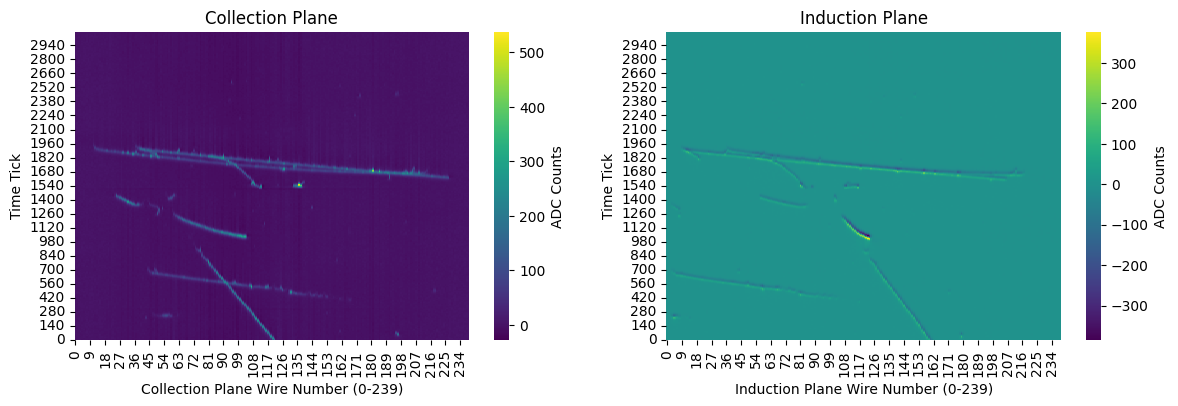

In [4]:
n = 200
event = Event(deuterons.iloc[n]['file_path'], index=deuterons.iloc[n]['event_index'])
# event = Event(deuteron_candidates.file_path[n], index=deuteron_candidates.event_index[n])
event.load()
event.plot()

Found 36 connected regions


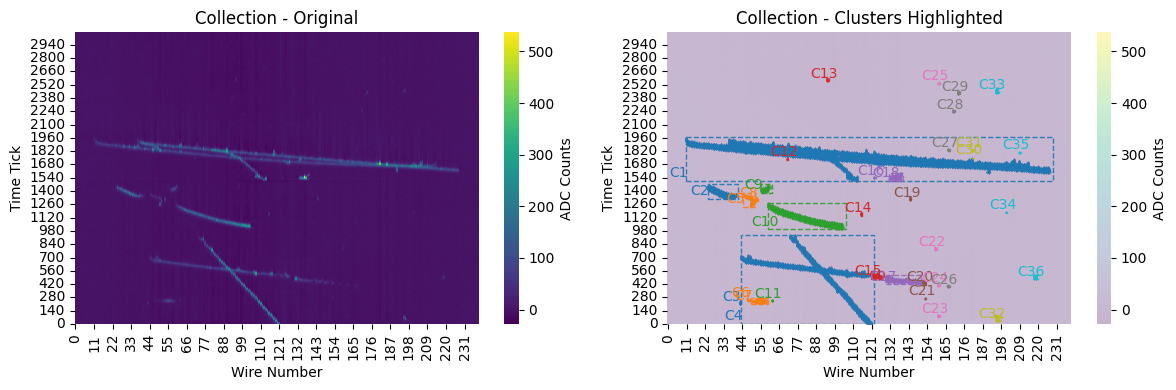

Found 40 connected regions


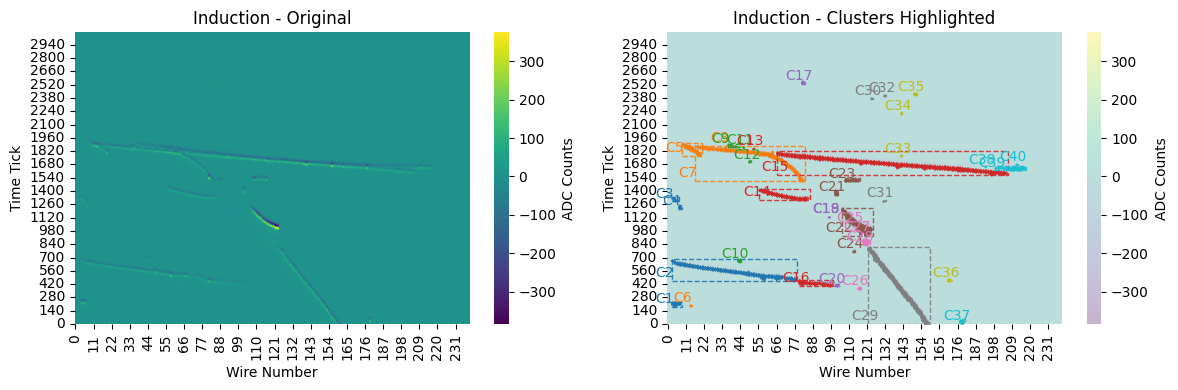

In [21]:
l, r = event.clustering(plane='collection', algo='connected', plot_mode='highlight')
l, r = event.clustering(plane='induction', algo='connected', plot_mode='highlight')